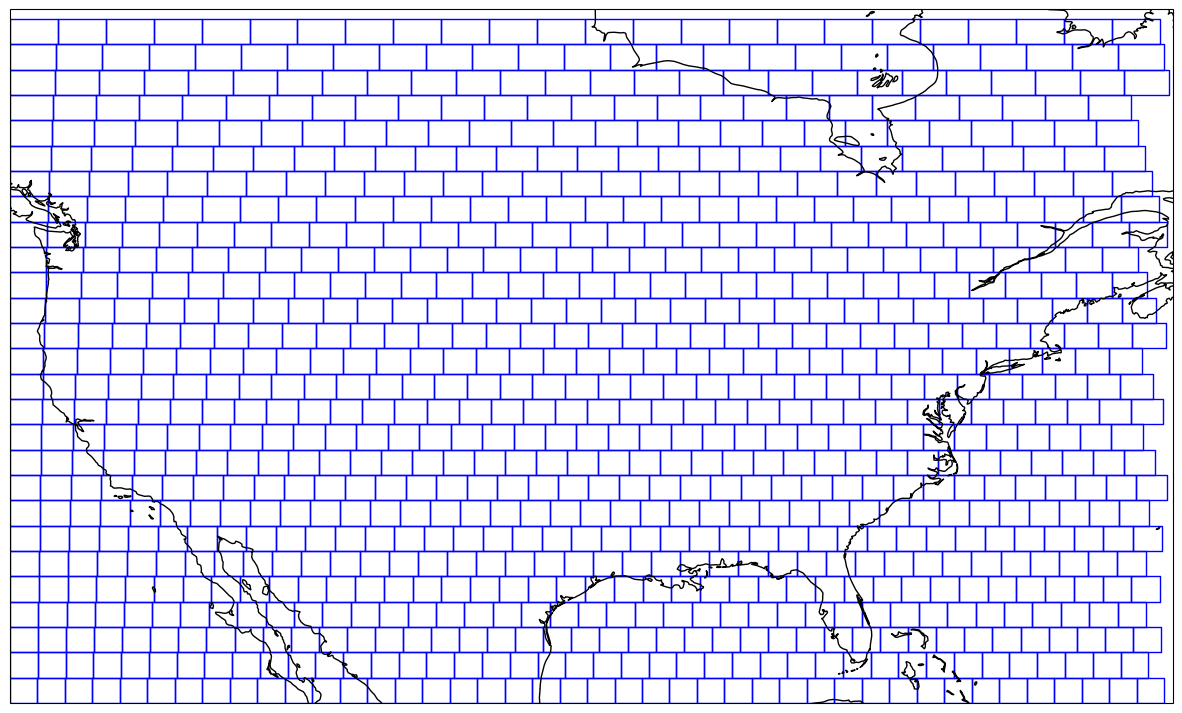

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from shapely.geometry.polygon import Polygon

# Define the extent and the size of each cell in kilometers
lat_start, lat_end = 23, 60
lon_start, lon_end = -126, -64
cell_km = 150  # 100 km x 100 km cells

# Function to calculate longitude step per latitude
def longitude_step(lat, km_per_cell):
    R = 6371  # Radius of Earth in km
    rad = np.deg2rad(lat)
    # Circumference of Earth at given latitude
    circ_km = 2 * np.pi * R * np.cos(rad)
    return km_per_cell / (circ_km / 360)

# Calculate grids
lats = np.arange(lat_start, lat_end, cell_km / 111)
grid_polygons = []

for lat in lats:
    lon_step = longitude_step(lat, cell_km)
    lons = np.arange(lon_start, lon_end, lon_step)
    for lon in lons:
        # Define the corners of the polygon
        if lon + lon_step < lon_end and lat + cell_km / 111 < lat_end:
            corners = [
                (lon, lat), 
                (lon + lon_step, lat), 
                (lon + lon_step, lat + cell_km / 111),
                (lon, lat + cell_km / 111)
            ]
            grid_polygons.append(Polygon(corners))

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_start, lon_end, lat_start, lat_end], crs=ccrs.PlateCarree())

# Plot each grid square as a polygon
for polygon in grid_polygons:
    ax.add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='blue')

# Add coastlines for reference
ax.coastlines()

# Show the plot
plt.show()


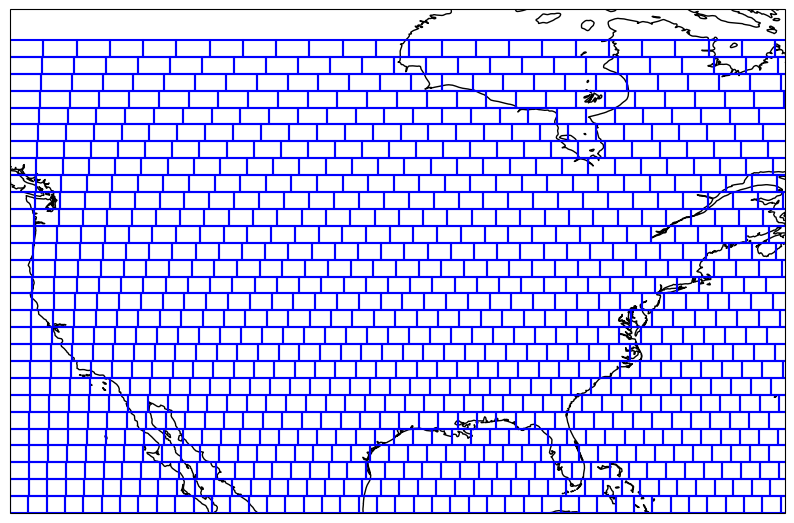

,geometry
0,"POLYGON ((-126.00000 23.00000, -124.53195 23.0..."
1,"POLYGON ((-124.53195 23.00000, -123.06389 23.0..."
2,"POLYGON ((-123.06389 23.00000, -121.59584 23.0..."
3,"POLYGON ((-121.59584 23.00000, -120.12778 23.0..."
4,"POLYGON ((-120.12778 23.00000, -118.65973 23.0..."


In [10]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Define the grid size and the extent
side_length_km = 150  # approx square root of 10000 km^2
lat_min, lat_max = 23, 60
lon_min, lon_max = -126, -64

# Calculate the approximate degree difference for 100 km in latitude
# 1 degree latitude ~ 111 km
deg_per_100km_lat = side_length_km / 111

# Calculate the approximate degree difference for 100 km in longitude at each latitude
def deg_per_100km_lon(lat):
    return side_length_km / (111 * np.cos(np.deg2rad(lat)))

# Create polygons for each grid cell
polygons = []
lats = np.arange(lat_min, lat_max, deg_per_100km_lat)
for lat in lats:
    lon_step = deg_per_100km_lon(lat)
    lons = np.arange(lon_min, lon_max, lon_step)
    for lon in lons:
        # Define the corners of the polygon
        corners = [
            (lon, lat),
            (lon + lon_step, lat),
            (lon + lon_step, lat + deg_per_100km_lat),
            (lon, lat + deg_per_100km_lat)
        ]
        poly = Polygon(corners)
        polygons.append(poly)

# Create a GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons})

# Plotting
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
grid.boundary.plot(ax=ax, edgecolor='blue')
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.coastlines()
plt.show()

grid.head()

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from pyproj import Proj, transform

# Define the Albers Equal Area projection using Cartopy
albers_projection = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=37.5)
platecarree_projection = ccrs.PlateCarree()

# Setup projection transformer
proj_transformer = Proj(albers_projection.proj4_init)

def create_grid(xmin, xmax, ymin, ymax, size_km2):
    """Create a grid of polygons within the given coordinates using the Albers Equal Area projection."""
    # Calculate grid cell size in degrees (roughly for area)
    width_km = np.sqrt(size_km2)
    height_km = np.sqrt(size_km2)
    width_deg = width_km / 111  # Approx. conversion from km to deg at equator
    height_deg = height_km / 111

    # Grid creation in geographic coordinates
    lon_range = np.arange(xmin, xmax, width_deg)
    lat_range = np.arange(ymin, ymax, height_deg)

    grid_polygons = []
    for lon in lon_range:
        for lat in lat_range:
            corners = [
                (lon, lat),
                (lon + width_deg, lat),
                (lon + width_deg, lat + height_deg),
                (lon, lat + height_deg)
            ]
            # Project corners to Albers to maintain area accuracy
            projected_corners = [transform(proj_transformer, lon, lat) for lon, lat in corners]
            grid_polygons.append(Polygon(projected_corners))

    grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons, crs=albers_projection.proj4_init)
    return grid_gdf

# Define bounds and grid cell size
xmin, xmax, ymin, ymax = -126, -64, 23, 60
grid_size_km2 = 10000

# Create the grid
grid_gdf = create_grid(xmin, xmax, ymin, ymax, grid_size_km2)

# Transform the grid to geographic coordinates for plotting
grid_gdf = grid_gdf.to_crs(epsg=4326)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': platecarree_projection})
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the grid
grid_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Display the plot
plt.title("Grid with Map Background")
plt.show()


TypeError: transform() missing 1 required positional argument: 'y'

In [24]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from pyproj import CRS, Transformer

# Latitude and Longitude bounds
lat_min, lat_max = 23, 60
lon_min, lon_max = -126, -64

# Distance between points in kilometers
distance_km = 150

# Use the Lambert Conformal Conic projection which is good for mid-latitudes in the US
crs_proj = CRS.from_proj4("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# Transformer to convert from geographic (longitude, latitude) to projected coordinates (x, y)
transformer_geo_to_proj = Transformer.from_crs("epsg:4326", crs_proj, always_xy=True)
transformer_proj_to_geo = Transformer.from_crs(crs_proj, "epsg:4326", always_xy=True)

# Transform the geographic bounds to the projected system
min_x, min_y = transformer_geo_to_proj.transform(lon_min, lat_min)
max_x, max_y = transformer_geo_to_proj.transform(lon_max, lat_max)

# Generate points grid in projected coordinates with given spacing in meters (150 km)
x_coords = np.arange(min_x, max_x, distance_km * 1000)
y_coords = np.arange(min_y, max_y, distance_km * 1000)
grid_points_proj = [Point(x, y) for x in x_coords for y in y_coords]

# Create a GeoDataFrame in the projected CRS
gdf_points_proj = gpd.GeoDataFrame(geometry=grid_points_proj, crs=crs_proj)

# Transform back to geographic coordinates (WGS 84)
gdf_points_geo = gdf_points_proj.to_crs('epsg:4326')

# Inspect some of the points and count them
gdf_points_geo.head(), len(gdf_points_geo)


(                      geometry
 0  POINT (-126.00000 23.00000)
 1  POINT (-126.48132 24.23883)
 2  POINT (-126.97720 25.48149)
 3  POINT (-127.48827 26.72738)
 4  POINT (-128.01520 27.97584),
 918)

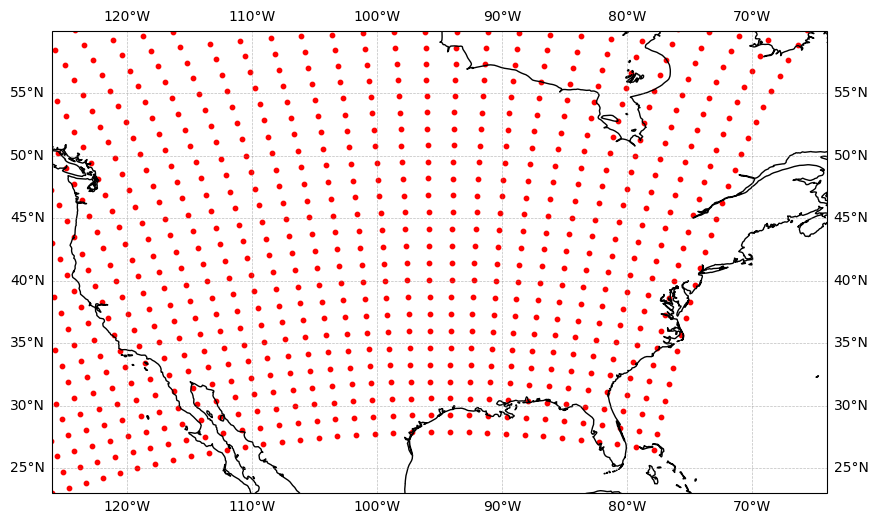

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Set up plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add coastlines for reference and gridlines for better visualization
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot points
lon, lat = gdf_points_geo["geometry"].x, gdf_points_geo["geometry"].y
ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree())

# Show the plot
plt.show()

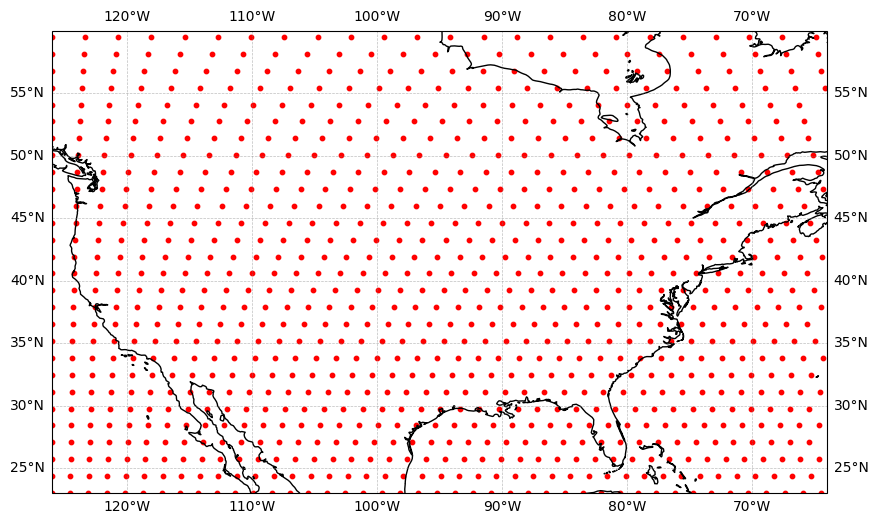

In [30]:
R = 6371.0  # Earth's radius in kilometers
one_degree_km = 111  # Approximate distance covered by one degree of latitude in km

# Calculate longitudinal distance for a latitude
def calculate_longitude_spacing(lat, distance_km):
    # Calculate the radius of the small circle at latitude
    r = R * np.cos(np.deg2rad(lat))
    # Calculate the distance covered by one degree of longitude at this latitude
    return distance_km / (np.pi * r / 180)

# Generate the grid
lats = np.arange(lat_min, lat_max, distance_km / one_degree_km)
grid_points_geo = []

for lat in lats:
    lon_step = calculate_longitude_spacing(lat, distance_km)
    lons = np.arange(lon_min, lon_max, lon_step)
    for lon in lons:
        grid_points_geo.append(Point(lon, lat))

# Create a GeoDataFrame
gdf_points_geo_direct = gpd.GeoDataFrame(geometry=grid_points_geo, crs="epsg:4326")

# Count the points and display some
len(gdf_points_geo_direct), gdf_points_geo_direct.head()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
lon, lat = zip(*[(point.x, point.y) for point in gdf_points_geo_direct.geometry])
ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree())

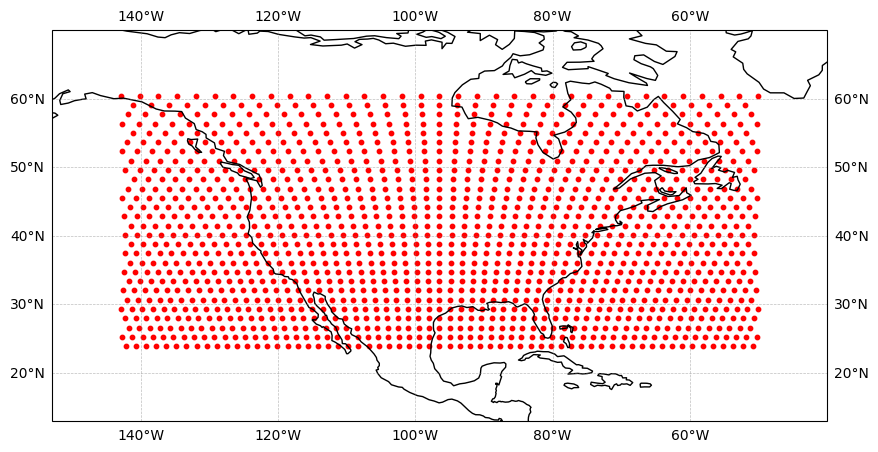

In [69]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

lat_min, lat_max = 23, 60
lon_min, lon_max = -143, -50
distance_km = 150
R = 6371.0
one_degree_km = 111 

def calculate_longitude_spacing(lat, distance_km):
    r = R * np.cos(np.deg2rad(lat))
    return distance_km / (np.pi * r / 180)

midpoint_lat = (lat_min + lat_max) / 2
midpoint_lon = (lon_min + lon_max) / 2

num_lon_steps_to_edge = int((midpoint_lon - lon_min) / calculate_longitude_spacing(midpoint_lat, distance_km))
lon_start = midpoint_lon - (num_lon_steps_to_edge * calculate_longitude_spacing(midpoint_lat, distance_km))

adjusted_lats = np.arange(lat_start, lat_max + (distance_km / one_degree_km), distance_km / one_degree_km)

grid_points_geo_centered_adaptive = []

for lat in adjusted_lats:
    current_lon_step = calculate_longitude_spacing(lat, distance_km)
    num_lon_steps_to_edge = int(np.ceil((midpoint_lon - lon_min) / current_lon_step))
    lon_start_at_lat = midpoint_lon - (num_lon_steps_to_edge * current_lon_step)
    adjusted_lons_at_lat = np.arange(lon_start_at_lat, lon_max + current_lon_step, current_lon_step)
    adjusted_lons_at_lat = adjusted_lons_at_lat[(adjusted_lons_at_lat >= lon_min) & (adjusted_lons_at_lat <= lon_max)]
    for lon in adjusted_lons_at_lat:
        grid_points_geo_centered_adaptive.append(Point(lon, lat))

gdf_points_geo_centered_adaptive = gpd.GeoDataFrame(geometry=grid_points_geo_centered_adaptive, crs="epsg:4326")
len(gdf_points_geo_centered_adaptive), gdf_points_geo_centered_adaptive.head()



fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min-10, lon_max+10, lat_min-10, lat_max+10], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
lon, lat = zip(*[(point.x, point.y) for point in gdf_points_geo_centered_adaptive.geometry])
ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree())

In [70]:
gdf = gdf_points_geo_centered_adaptive.copy()
gdf

,geometry
0,POINT (-142.25201 23.93243)
1,POINT (-140.77614 23.93243)
2,POINT (-139.30027 23.93243)
3,POINT (-137.82439 23.93243)
4,POINT (-136.34852 23.93243)
...,...
1401,POINT (-60.97563 60.41892)
1402,POINT (-58.24299 60.41892)
1403,POINT (-55.51035 60.41892)
1404,POINT (-52.77770 60.41892)


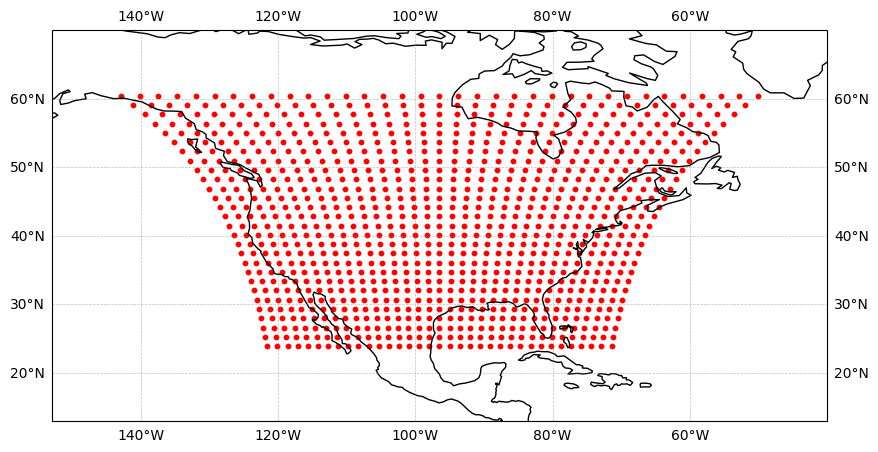

In [71]:
gdf['latitude'] = gdf['geometry'].y
gdf['longitude'] = gdf['geometry'].x

# Calculate the median longitude
median_longitude = gdf['longitude'].median()

def select_closest_points(group):
    # Calculate the absolute distance from the median longitude
    group['dist_to_median'] = (group['longitude'] - median_longitude).abs()
    # Sort by this distance
    sorted_group = group.sort_values('dist_to_median')
    # Select up to 34 closest points
    closest_points = sorted_group.head(35)
    return closest_points

# Group by latitude, apply the function, and concatenate the results
filtered_gdf = gdf.groupby('latitude').apply(select_closest_points).reset_index(drop=True)

# Drop the temporary distance column if you no longer need it
filtered_gdf.drop(columns=['dist_to_median'], inplace=True)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min-10, lon_max+10, lat_min-10, lat_max+10], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
lon, lat = zip(*[(point.x, point.y) for point in filtered_gdf.geometry])
ax.scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree())

In [39]:
import pandas as pd

data = {'latitude': [45, 35], 'longitude': [-75, -80]}
df = pd.DataFrame(data)

df_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="epsg:4326")


In [45]:
# We need to reorganize grid_points_geo_centered_adaptive from a list into a 2D list where each sublist represents a row of latitude
from collections import defaultdict

grid_dict = defaultdict(list)

# Populate dictionary with latitude as keys and list of points at that latitude as values
for point in grid_points_geo_centered_adaptive:
    grid_dict[point.y].append(point)

# Sort each latitude's points by longitude and convert dictionary to sorted list by latitude
sorted_latitudes = sorted(grid_dict.keys())
sorted_grid = [sorted(grid_dict[lat], key=lambda p: p.x) for lat in sorted_latitudes]
from shapely.geometry import Polygon
import geopandas as gpd

# Assuming 'sorted_grid' is already defined as per your previous implementation
polygons = []

for i in range(len(sorted_grid) - 1):  # Iterate up to the second-to-last latitude row
    for j in range(min(len(sorted_grid[i]), len(sorted_grid[i+1])) - 1):  # Iterate safely within the shortest row length
        # Define four corners of the polygon
        p1 = sorted_grid[i][j]
        p2 = sorted_grid[i][j+1]
        p3 = sorted_grid[i+1][j+1]
        p4 = sorted_grid[i+1][j]

        # Create the polygon using these four corners
        polygon = Polygon([p1, p2, p3, p4, p1])
        polygons.append(polygon)

# Create a GeoDataFrame with these polygons
gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs="epsg:4326")



# Perform spatial join
joined = gpd.sjoin(gdf_polygons, df_points, how="inner", op="contains")

# Create a column to indicate polygons with points
gdf_polygons['contains_point'] = gdf_polygons.index.isin(joined.index)


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<GeoAxes: >

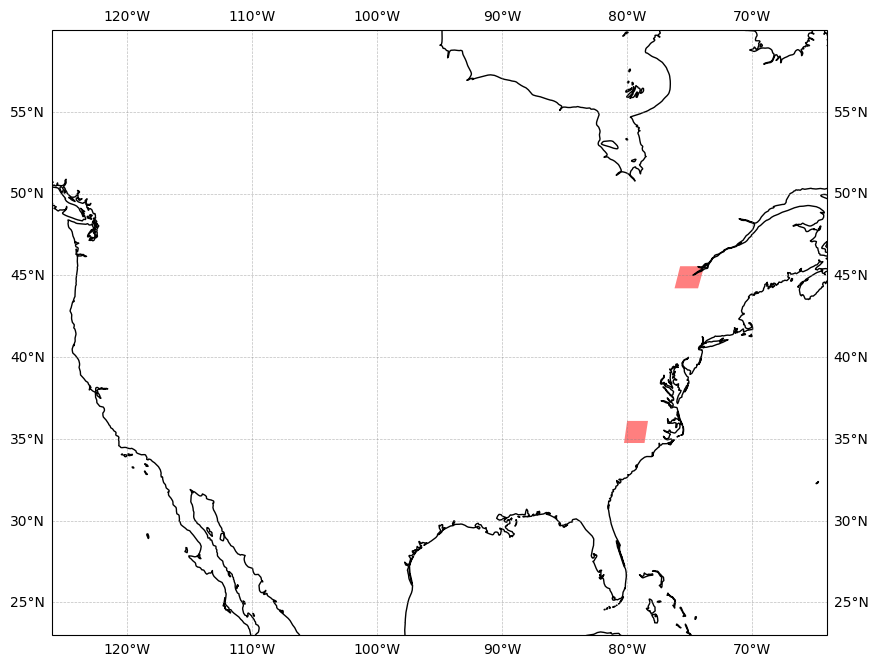

In [48]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot polygons
gdf_polygons[gdf_polygons['contains_point']].plot(ax=ax, color='red', alpha=0.5, transform=ccrs.PlateCarree())  # Contains points
#gdf_polygons[~gdf_polygons['contains_point']].plot(ax=ax, color='blue', alpha=0.5, transform=ccrs.PlateCarree())  # Does not contain points
